In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.compat.v1 import ConfigProto , Session, InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
import gc

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(Session(config=config));
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2021-08-27 09:21:42.571374: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-27 09:21:43.091209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:21:44.216079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:21:44.217423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Préparation des échantillons

In [4]:
def data_transformation(df):
    data = df.T
    data["path_to_image"]="../raw_data/IMG/"+data["image_name"]
    data['species'] = data['genus']+' '+data['specific_epithet']
    return data

In [5]:
def X_y_from_df(df, sample_size, resize_size=256):
    data_sample = df.sample(sample_size, random_state = 818)
    image = []

    for i in data_sample['path_to_image'] :
        img = Image.open(i)
        img = img.resize((resize_size, resize_size))
        image.append(np.array(img))

    X = np.array(image)
    y = np.array(data_sample['species'])
    return X, y

In [6]:
pwd

'/home/zac/code/Em3line/Butterfly_identification/notebooks'

In [7]:
ds = image_dataset_from_directory(
  "/home/zac/code/Em3line/Butterfly_identification/raw_data",
  batch_size=32,
  image_size=(128, 128))

Found 92694 files belonging to 2 classes.


2021-08-27 09:21:59.962860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:21:59.963205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:21:59.963452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:21:59.963866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:21:59.964115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
for i, j in ds:
    #print(i)
    print(j)
    break

2021-08-27 09:22:00.388916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor([0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0], shape=(32,), dtype=int32)


# Lancement du modèle

In [9]:
def model_VGG16( X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, image_size,  patience=2, learning_rate=0.001, nb_epochs=15, nb_couches_dense_layer=130):
    
    model = VGG16(weights="imagenet", include_top=False, input_shape = image_size)



    model.trainable = False
    
    #add last layers
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(nb_couches_dense_layer, activation='relu')
    dropout_layer1 = layers.Dropout(.2, input_shape=(2,))
    dense_layer2 = layers.Dense(1000, activation='relu')
    dropout_layer2 = layers.Dropout(.2, input_shape=(2,))
    prediction_layer = layers.Dense(366, activation='softmax')
    model = models.Sequential([
        model,
        flatten_layer,
        dense_layer,
        dropout_layer1,
        dense_layer2,
        dropout_layer2,
        prediction_layer
    ])
    
    #build model
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    model.summary()
    
    #set earlystopping
    es = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
    
    #launch model
    history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_val, y_val_cat), 
                    epochs=nb_epochs, 
                    batch_size=32, 
                    callbacks=[es])
    
    #evaluate model
    res_vgg = model.evaluate(X_test, y_test_cat)
    
    test_accuracy_vgg = res_vgg[-1]
    
    return (f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %"), history

# Courbes d'apprentissage

In [10]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [11]:
df_train = data_transformation(pd.read_json('~/code/Em3line/Butterfly_identification/raw_data/ETHEC_dataset/splits/train.json'))
df_val = data_transformation(pd.read_json('~/code/Em3line/Butterfly_identification/raw_data/ETHEC_dataset/splits/val.json'))
df_test = data_transformation(pd.read_json('~/code/Em3line/Butterfly_identification/raw_data/ETHEC_dataset/splits/test.json'))

X_val, y_val = X_y_from_df(df_val, 800, 128)
X_test, y_test = X_y_from_df(df_test, 800, 128)
X_train, y_train = X_y_from_df(df_train, 4000, 128)

y_train = y_train.reshape(4000, 1)
y_val = y_val.reshape(800, 1)
y_test = y_test.reshape(800, 1)


X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

del df_train
del df_test
del df_val



In [12]:

ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
ohe.fit(y_train)
print(pd.DataFrame(y_train).nunique())
y_train_cat = ohe.transform(y_train)
y_val_cat = ohe.transform(y_val)
y_test_cat = ohe.transform(y_test)
del y_train
del y_test
del y_val
del ohe
gc.collect();

0    366
dtype: int64


In [13]:
gc.garbage

[]

In [14]:
check, model = model_VGG16(X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, X_train[0].shape, 3, 0.001, 50, 2000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2000)              16386000  
_________________________________________________________________
dropout (Dropout)            (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 366)               3

2021-08-27 09:24:42.057356: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 786432000 exceeds 10% of free system memory.
2021-08-27 09:24:42.559306: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/50


2021-08-27 09:24:45.524717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202
2021-08-27 09:24:50.452092: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-27 09:24:55.081701: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-27 09:24:55.081772: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

125/125 [==============================] - 29s 107ms/step - loss: 6.1997 - accuracy: 0.2425 - val_loss: 2.6101 - val_accuracy: 0.3837
Epoch 2/50
125/125 [==============================] - 13s 104ms/step - loss: 2.4940 - accuracy: 0.4688 - val_loss: 1.9043 - val_accuracy: 0.4800
Epoch 3/50
125/125 [==============================] - 13s 106ms/step - loss: 1.9593 - accuracy: 0.5495 - val_loss: 1.6334 - val_accuracy: 0.4938
Epoch 4/50
125/125 [==============================] - 13s 105ms/step - loss: 1.6149 - accuracy: 0.5970 - val_loss: 1.2442 - val_accuracy: 0.5950
Epoch 5/50
125/125 [==============================] - 13s 107ms/step - loss: 1.2731 - accuracy: 0.6740 - val_loss: 1.1984 - val_accuracy: 0.6175
Epoch 6/50
125/125 [==============================] - 13s 108ms/step - loss: 1.2156 - accuracy: 0.6873 - val_loss: 1.1957 - val_accuracy: 0.6087
Epoch 7/50
125/125 [==============================] - 14s 109ms/step - loss: 1.1313 - accuracy: 0.7035 - val_loss: 1.1897 - val_accuracy: 0.6

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

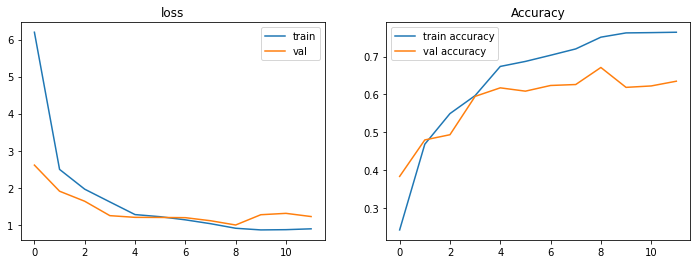

In [15]:
plot_history(model)

In [ ]:
del check
del model


In [ ]:
del ohe

In [ ]:
gc.collect()

In [17]:
gc.garbage

[]

In [ ]:
#plot_history(model_256)

# Historique

In [ ]:
plt.imshow(X_train[0])

In [ ]:
X_train[0].shape

In [ ]:
model_VGG16(X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, X_train[0].shape, 5, 0.001, 15, 130)

In [ ]:
#model = load_model()
#model.summary()

In [ ]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    
    return model

model
model = set_nontrainable_layers(model)

model.summary()

In [ ]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(130, activation='relu')
    prediction_layer = layers.Dense(248, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [ ]:
model = add_last_layers(model)
model.summary()

In [ ]:
from tensorflow.keras import optimizers

def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
    # $CHALLENGIFY_END

In [ ]:
model = build_model()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    # $CHALLENGIFY_BEGIN
    model = VGG16(weights="imagenet", include_top=False, input_shape=image[0].shape)
    # $CHALLENGIFY_END
    
    return model

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
y_train

In [ ]:
y_train.shape

In [ ]:
y_val.shape

In [ ]:
y_cat.shape

In [ ]:
y_val_cat.shape

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='max', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_cat, 
                    validation_data=(X_val, y_val_cat), 
                    epochs=20, 
                    batch_size=16, 
                    callbacks=[es])

In [ ]:
res_vgg = model.evaluate(X_test, y_test_cat)

test_accuracy_vgg = res_vgg[-1]

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")